# Top Suburbs

In [285]:
import pandas as pd
import _pickle as cPickle

In [315]:
result_suburbs = []

In [287]:
df = pd.read_csv('../data/curated/processed_listing.csv')

In [288]:
df = df.drop_duplicates(subset='address')

In [289]:
# read in the postcode information
df = df.rename(columns={'code': 'postcode'}, errors="coerce")
postcode_df = pd.read_csv('../data/raw/abs/australian_postcodes.csv')
# only retain information that is relavent for faster running time
postcode_df = postcode_df.loc[postcode_df['state'] == 'VIC']
postcode_df = postcode_df[['postcode', 'lgaregion']]
df = pd.merge(df, postcode_df, on='postcode')
metro_melb = ['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Cardinia', 'Casey', 'Darebin', 'Frankston', 'Glen Eira',
              'Greater Dandenong', 'Hobsons Bay', 'Hume', 'Kingston', 'Knox', 'Manningham', 'Maribyrnong', 'Maroondah',
              'Melbourne', 'Melton', 'Monash', 'Moonee Valley', 'Moreland', 'Mornington Peninsula', 'Nillumbik',
              'Port Phillip', 'Stonnington', 'Whitehorse', 'Whittlesea', 'Wyndham', 'Yarra', 'Yarra Ranges']
df = df.loc[df['lgaregion'].isin(metro_melb)]

In [290]:
stats_df = df[['suburb','weekly_rent']].groupby('suburb').mean()
stats_df = stats_df.merge(df.groupby('suburb').count().iloc[:,0], on = 'suburb')
stats_df = stats_df.set_axis(['ave_weekly_rent', 'n_listing'], axis=1)

In [291]:
min_listing = stats_df.n_listing.quantile(0.25)
print(min_listing)

38.25


In [292]:
stats_df = stats_df.sort_values(by = 'ave_weekly_rent', ascending = True)
stats_df = stats_df.loc[stats_df['n_listing'] >= min_listing]
stats_df.head()

,ave_weekly_rent,n_listing
suburb,,
Millgrove,299.166667,42
Albion,312.983607,610
Broadford,321.206897,319
Melton South,322.405694,1967
Campbellfield,323.785714,42


In [316]:
result_suburbs.append(stats_df.iloc[0:2].index.tolist())

In [294]:
# full_df = pd.read_csv('../data/curated/full_listing.csv').iloc[:,1:]
full_df = pd.read_csv('../data/curated/full_listing.csv').iloc[:,1:]
remove = [ 'address', 'postcode', 'url', 'loc_address', 'lat', 'lon', 'list_date', 'list_history', 'list_count', 'SA2_NAME_2016', 'SA2', 'lgaregion', 'primary_school_name', 'secondary_school_name', 'pri_lat', 'pri_lon', 'sec_lat', 'sec_lon', 'closest_ed_name', 'ed_lat', 'ed_lon', 'train_stop', 'train_lat', 'train_lon']
full_df = full_df.drop(remove, axis=1)

In [295]:
full_df = full_df[full_df.groupby('suburb')['suburb'].transform('count').ge(min_listing)]

In [296]:
rank_df = full_df.groupby('suburb').mean()
rank_df[['bed', 'bath', 'car', 'type_code']] = [2, 1, 1, 4]

/var/folders/y5/myhyydfd6h9dlwv1qmqtqhmr0000gn/T/ipykernel_36092/1249762198.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rank_df = full_df.groupby('suburb').mean()


In [297]:
with open('../models/rf_regressor', 'rb') as f:
    rf = cPickle.load(f)
x = rank_df.drop(['weekly_rent'], axis=1).dropna()
x.head()

,bed,bath,car,income_earner,income_median_age,income_median,income_mean,income_top_10_pct,population_total,population_children,...,primary_duration,secondary_distance,secondary_duration,ed_distance,ed_duration,train_distance,train_duration,melb_distance,melb_duration,type_code
suburb,,,,,,,,,,,,,,,,,,,,,
Abbotsford,2,1,1,6589.0,33.0,64090.0,78181.0,30.2,9262.0,759.0,...,219.671429,2064.853571,451.067857,2196.725000,406.503571,1768.028571,337.528571,4136.603571,795.582143,4
Airport West,2,1,1,4842.0,41.0,58506.0,65204.0,25.9,8237.0,1384.0,...,203.368852,4165.377049,487.459016,12829.704918,961.418033,7147.155738,662.811475,16300.836066,1225.368852,4
Albert Park,2,1,1,11685.0,44.0,67518.0,120412.0,48.3,16023.0,2165.0,...,126.307692,1013.903846,160.942308,4042.903846,570.980769,4516.826923,643.769231,5980.884615,980.442308,4
Albion,2,1,1,4479.0,35.0,44333.0,50078.0,26.4,7595.0,1171.0,...,110.671642,3403.059701,378.656716,5581.298507,722.373134,1853.134328,286.328358,14692.313433,1682.537313,4
Alphington,2,1,1,5937.0,40.0,61806.0,84148.0,34.6,9072.0,1453.0,...,168.254237,3604.813559,464.813559,4803.593220,599.830508,944.237288,155.169492,9286.677966,1086.779661,4


In [324]:
prediction = pd.DataFrame({'suburb': x.index.tolist(), 'score': rf.predict(x)}).sort_values(by='score', ascending=False)
prediction['score'] = (prediction['score']-prediction['score'].mean())/prediction['score'].std()
prediction

,suburb,score
91,Fitzroy,4.223652
92,Fitzroy North,4.208086
2,Albert Park,4.089083
47,Carlton North,3.495368
81,East Melbourne,3.253756
...,...,...
193,St Albans,-1.601386
72,Dandenong North,-1.662169
13,Bacchus Marsh,-1.662644
108,Hastings,-1.744304


In [328]:
from math import floor, ceil

In [332]:
bins = []
i = floor(min(prediction['score']))
while i < ceil(max(prediction['score'])):
    bins.append(i)
    i += 0.5
print(bins)

[-2, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]


array([[<AxesSubplot: title={'center': 'score'}>]], dtype=object)

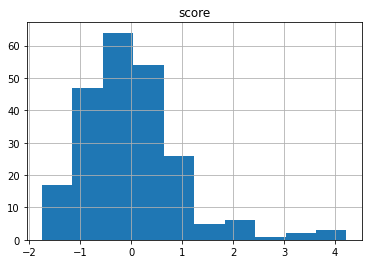

In [323]:
prediction.hist(column='score')

In [317]:
result_suburbs.append(prediction.iloc[0:3,0].tolist())

In [318]:
result_suburbs

[['Millgrove', 'Albion'], ['Fitzroy', 'Fitzroy North', 'Albert Park']]

In [319]:
result_suburbs.append(prediction.iloc[-2:,0].tolist())

In [320]:
result_suburbs = [item for sublist in result_suburbs for item in sublist]

In [322]:
for i in result_suburbs:
    if len(full_df[full_df['suburb']==i]) > 0:
        print(f'=============={i}==============')
        print('Listing count: ', len(full_df[full_df['suburb']==i]))
        print(full_df[full_df['suburb']==i].mean(axis=0))

==============Albion==============
Listing count:  67
bed                                   2.268657
bath                                  1.223881
car                                   1.402985
weekly_rent                         332.671642
income_earner                      4479.000000
income_median_age                    35.000000
income_median                     44333.000000
income_mean                       50078.000000
income_top_10_pct                    26.400000
population_total                   7595.000000
population_children                1171.000000
population_prime_working           3774.000000
population_elderly                 1168.000000
population_early_working            784.000000
population_mature_working           698.000000
secondary_school_rank                17.253731
secondary_school_cohort             287.343284
proj_population_total             10531.000000
proj_population_children           1976.000000
proj_population_early_working      1174.000000
proj_p

/var/folders/y5/myhyydfd6h9dlwv1qmqtqhmr0000gn/T/ipykernel_36092/1940590245.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(full_df[full_df['suburb']==i].mean(axis=0))
